Text(0.5, 1.0, 'Output')

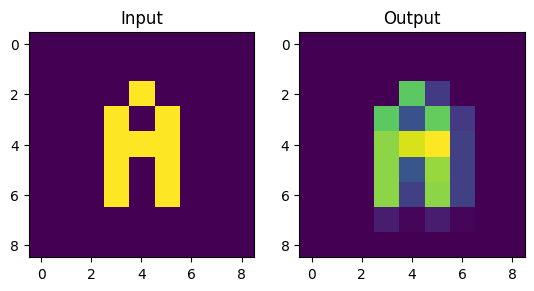

In [44]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img1 = np.array([[0,0,255,0,0],
                 [0,255,0,255,0],
                 [0,255,255,255,0],
                 [0,255,0,255,0],
                 [0,255,0,255,0]]).astype(np.uint8)
img1 = cv2.copyMakeBorder(img1, 2, 2, 2, 2, cv2.BORDER_CONSTANT, value=0)
# img2 = cv2.GaussianBlur(img1, (5,5), 0.2)
img2 = img1.copy()
# 设置仿射变换
rows, cols = img1.shape
M = np.array([[1,0,0.2],
                [0,1,0.1]]).astype(np.float32)
img2 = cv2.warpAffine(img2,M,(cols,rows))
plt.subplot(121);plt.imshow(img1);plt.title('Input')
plt.subplot(122);plt.imshow(img2);plt.title('Output')


In [48]:
h0 = 0;h1 = 1;a0 = 0;a1 = 1;a2 = 0;b0 = 0;b1 = 0;b2 = 1
param = {"h0":h0,"h1":h1,"a0":a0,"a1":a1,"a2":a2,"b0":b0,"b1":b1,"b2":b2}
def trans2d(xy:tuple,param:dict):
    x,y = xy
    h0,h1,a0,a1,a2,b0,b1,b2 = param["h0"],param["h1"],param["a0"],param["a1"],param["a2"],param["b0"],param["b1"],param["b2"]
    x2,y2 = a0+a1*x+a2*y,b0+b1*x+b2*y
    return (x2,y2)
def resample(xy,img:np.ndarray):
    x,y = xy
    dy_frac = y - int(y)
    dx_frac = x - int(x)
    iy = int(y)
    ix = int(x)
    if iy >= 0 and iy < img.shape[0]-1 and ix >= 0 and ix < img.shape[1]-1:
        interp_val = (img[iy, ix] * (1-dx_frac) * (1-dy_frac) +
                    img[iy, ix+1] * dx_frac * (1-dy_frac) +
                    img[iy+1, ix] * (1-dx_frac) * dy_frac +
                    img[iy+1, ix+1] * dx_frac * dy_frac)   
    return interp_val

srcPt,dstPt = (4,4),(4,4)
srcPt = trans2d(srcPt,param)
dstGray = resample(srcPt,img2)*h1 + h0
srcGray = img1[srcPt[1],srcPt[0]]
err = srcGray - dstGray
print(err)




19


In [42]:
def subpixel_matching_iterative(img1, img2, initial_point, window_size=5, max_iterations=10, epsilon=0.1):
    """
    使用迭代最小二乘法进行亚像素特征点匹配
    
    Parameters:
    img1: 第一幅图像（参考图像）
    img2: 第二幅图像（目标图像）
    initial_point: 初始匹配点坐标 (y, x)
    window_size: 匹配窗口大小
    max_iterations: 最大迭代次数
    epsilon: 收敛阈值
    
    Returns:
    refined_point: 精细化后的匹配点坐标
    iterations: 实际迭代次数
    """
    
    y, x = initial_point
    half_window = window_size // 2
    
    # 提取参考窗口
    y_start, y_end = max(0, y-half_window), min(img1.shape[0], y+half_window+1)
    x_start, x_end = max(0, x-half_window), min(img1.shape[1], x+half_window+1)
    print(y_start, y_end, x_start, x_end)
    ref_window = img1[y_start:y_end, x_start:x_end].astype(np.float64)
    
    # 计算参考窗口的梯度
    grad_x = np.zeros_like(ref_window)
    grad_y = np.zeros_like(ref_window)
    
    # 使用中心差分计算梯度
    grad_x[:, 1:-1] = (ref_window[:, 2:] - ref_window[:, :-2]) / 2.0
    grad_y[1:-1, :] = (ref_window[2:, :] - ref_window[:-2, :]) / 2.0
    
    # 构建正规方程组的系数矩阵
    A = np.zeros((2, 2))
    A[0, 0] = np.sum(grad_x * grad_x)
    A[0, 1] = np.sum(grad_x * grad_y)
    A[1, 0] = A[0, 1]
    A[1, 1] = np.sum(grad_y * grad_y)
    
    # 检查矩阵是否可逆
    det_A = A[0, 0] * A[1, 1] - A[0, 1] * A[1, 0]
    if abs(det_A) < 1e-10:
        print("Warning: Gradient matrix is singular, returning initial point")
        return (y, x), 0
    
    # 当前估计的位置偏移
    delta_y, delta_x = 0.0, 0.0
    
    # 迭代优化
    for iteration in range(max_iterations):
        # 计算当前估计位置
        current_y = y + delta_y
        current_x = x + delta_x
        
        # 提取目标图像中对应区域的插值
        error_sum = 0.0
        b = np.zeros(2)
        
        valid_points = 0
        for i in range(ref_window.shape[0]):
            for j in range(ref_window.shape[1]):
                # 目标图像中的实际坐标
                target_y = current_y + i - (y_end - y_start) // 2
                target_x = current_x + j - (x_end - x_start) // 2
                
                # 检查边界
                if (0 <= target_y < img2.shape[0]-1) and (0 <= target_x < img2.shape[1]-1):
                    # 双线性插值获取目标点像素值
                    dy_frac = target_y - int(target_y)
                    dx_frac = target_x - int(target_x)
                    
                    iy = int(target_y)
                    ix = int(target_x)
                    
                    if iy >= 0 and iy < img2.shape[0]-1 and ix >= 0 and ix < img2.shape[1]-1:
                        interp_val = (img2[iy, ix] * (1-dx_frac) * (1-dy_frac) +
                                    img2[iy, ix+1] * dx_frac * (1-dy_frac) +
                                    img2[iy+1, ix] * (1-dx_frac) * dy_frac +
                                    img2[iy+1, ix+1] * dx_frac * dy_frac)
                        
                        # 计算误差
                        error = ref_window[i, j] - interp_val
                        # print("Error:", error)
                        
                        # 构建正规方程的右侧向量
                        b[0] += error * grad_x[i, j]
                        b[1] += error * grad_y[i, j]
                        error_sum += abs(error)
                        valid_points += 1
        
        if valid_points == 0:
            print("Warning: No valid points found, returning current estimate")
            return (current_y, current_x), iteration
        
        # 解正规方程
        try:
            delta = np.linalg.solve(A, b)
        except np.linalg.LinAlgError:
            print("Warning: Cannot solve linear system, returning current estimate")
            return (current_y, current_x), iteration
        
        # 更新位置估计
        delta_y += delta[1]
        delta_x += delta[0]
        
        print("Iteration:", iteration+1, "Error:", error_sum)
        print("Delta:", delta)
        # 检查收敛性
        if np.linalg.norm(delta) < epsilon:
            break
    
    refined_point = (y + delta_y, x + delta_x)
    return refined_point, iteration + 1

refined_point = subpixel_matching_iterative(img1, img2, (4, 4))
print("Refined Point:", refined_point)

2 7 2 7
Iteration: 1 Error: 144.0
Delta: [0.         0.18823529]
Iteration: 2 Error: 421.270588235294
Delta: [0.         0.15280277]
Iteration: 3 Error: 646.349065743944
Delta: [0.         0.12403989]
Iteration: 4 Error: 829.0598298392025
Delta: [0.         0.10069121]
Iteration: 5 Error: 977.3779795165292
Delta: [0.         0.08173757]
Refined Point: ((np.float64(4.647506733649938), np.float64(4.0)), 5)
